In [3]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

### Entropy

In [4]:
entropy = pd.read_csv('data/entropy.csv')

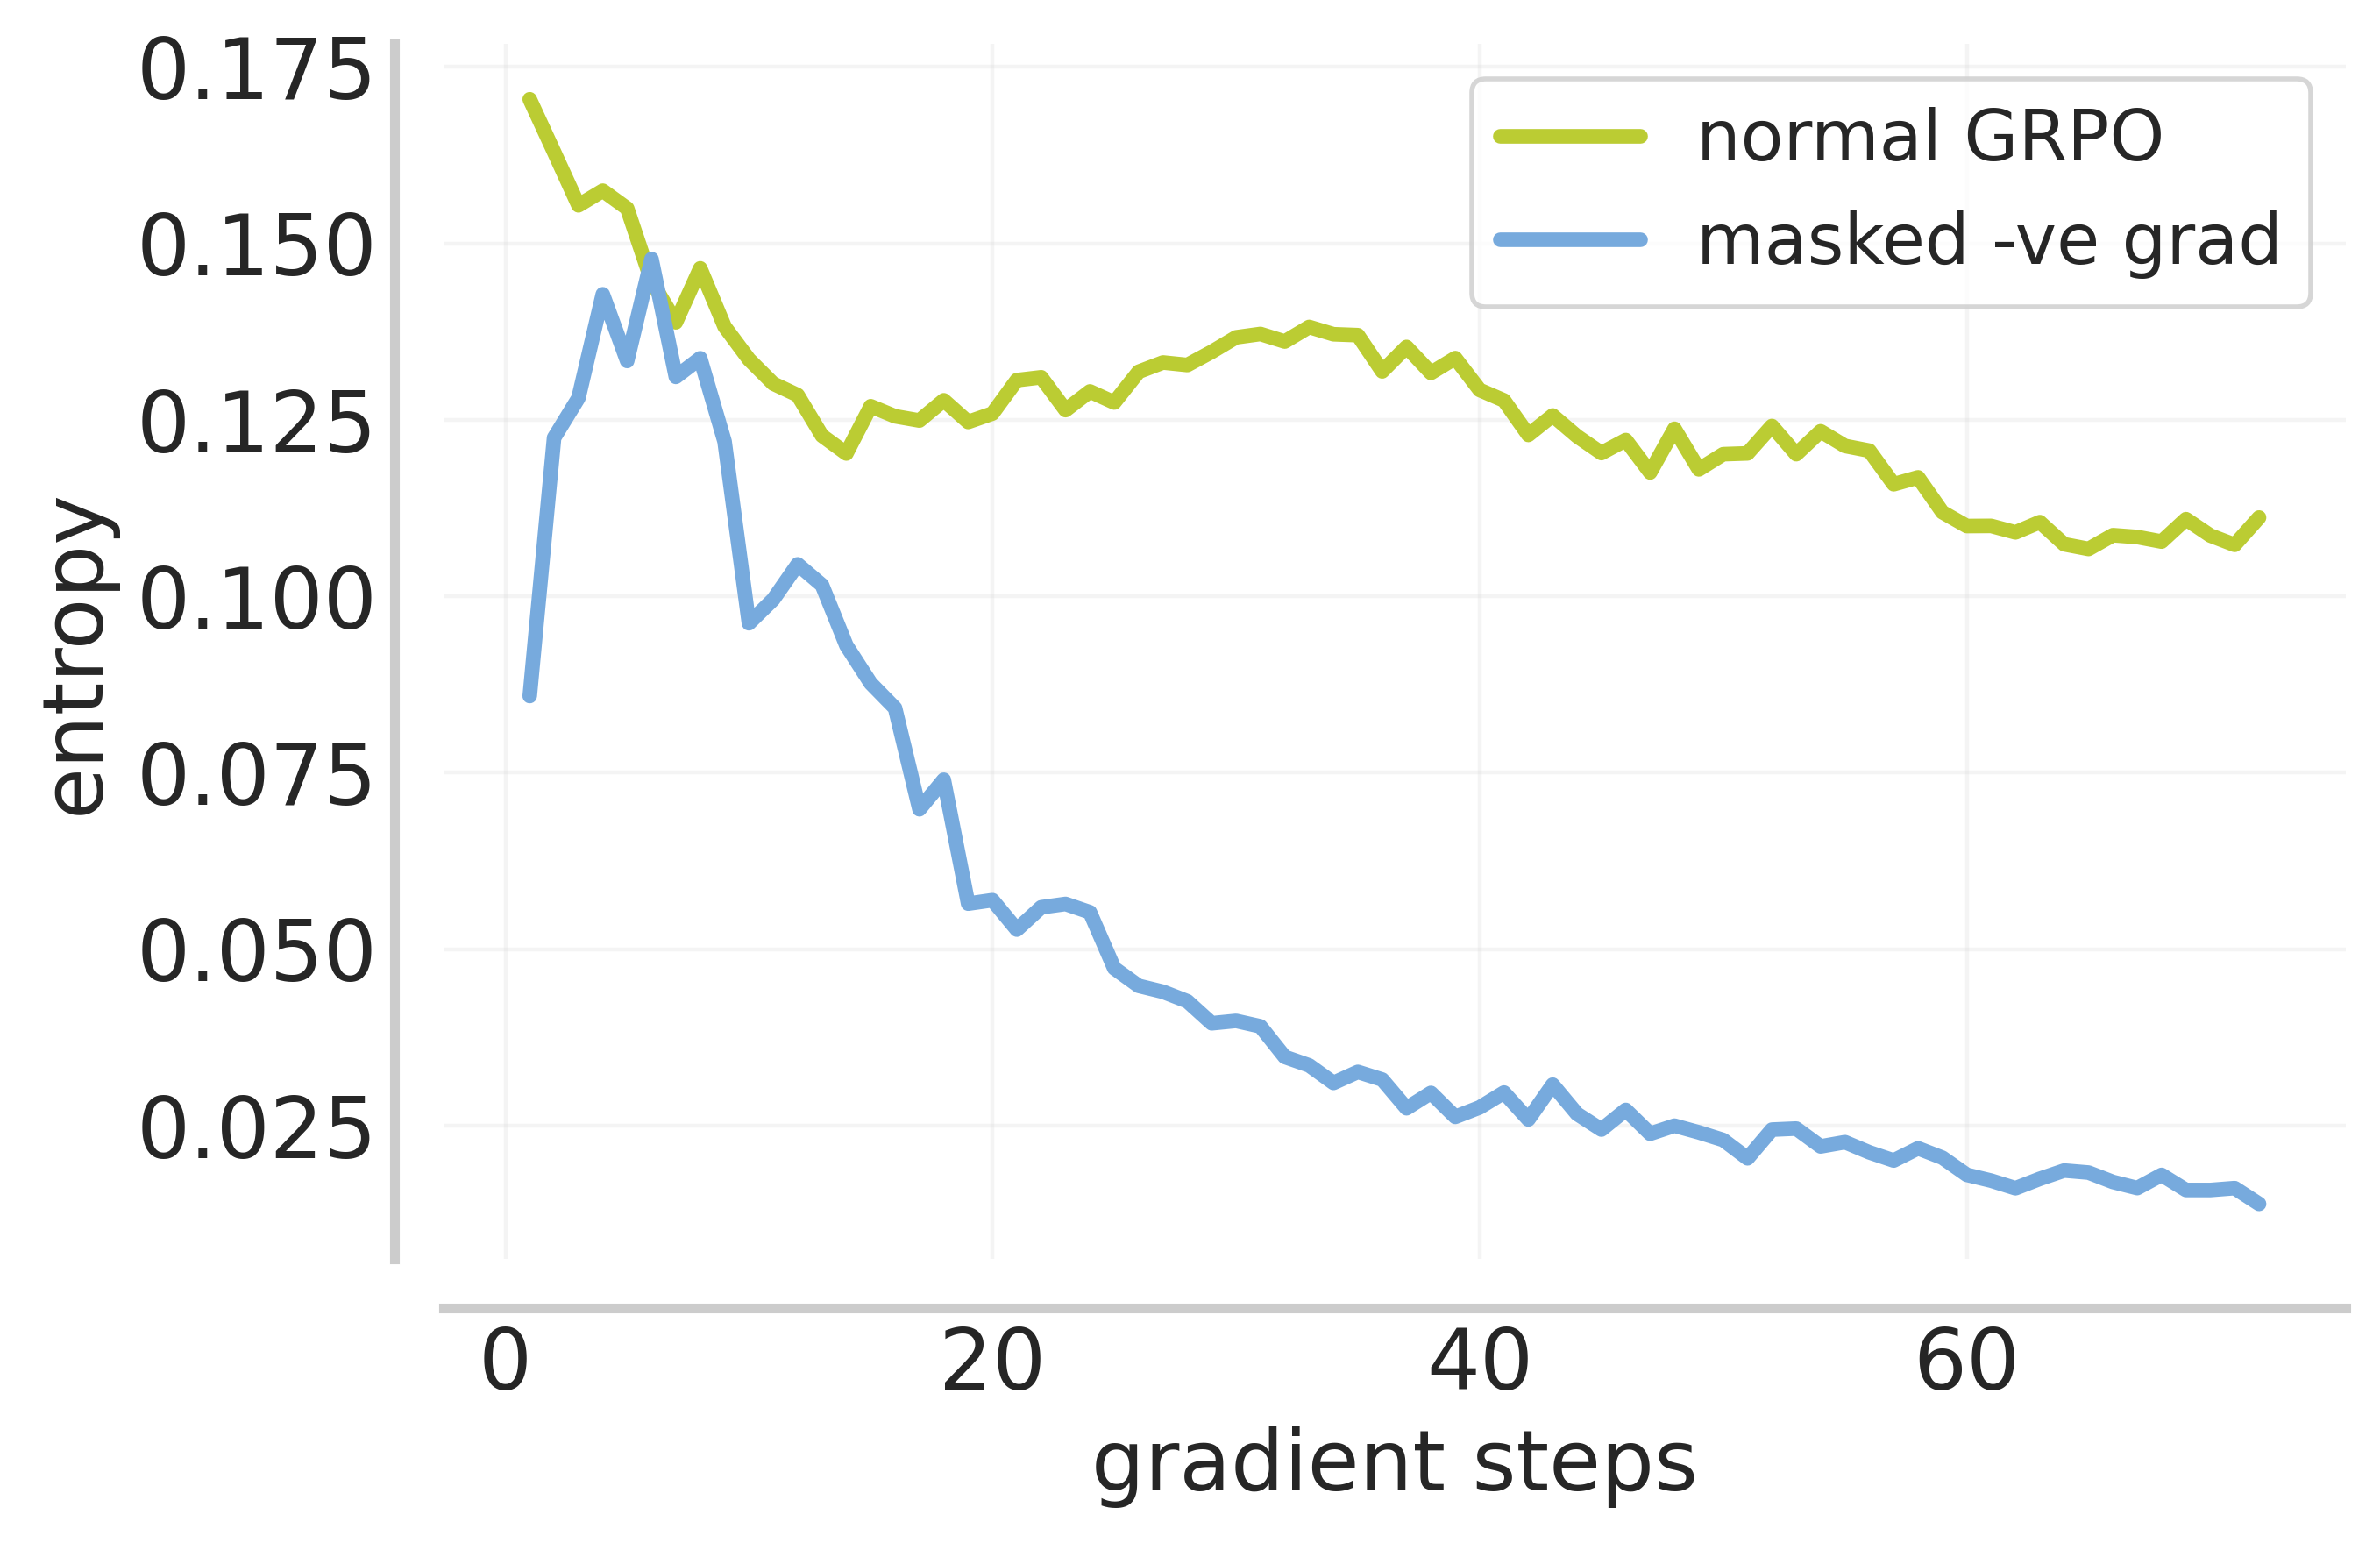

In [11]:
fig, ax = plt.subplots(figsize=(14 / 2, 4.5), dpi=400)
# ax.axvline(16384, 0, 1, color='black')
# ax.axvspan(16384, 32768, alpha=0.3, color='gray')
# txt = ax.text(0.7, 0.45, "extrapolation with \n budget forcing", fontsize=16, color='black', ha='center', linespacing=1.5, transform=ax.transAxes)

sns.lineplot(data=entropy, x='Step', y='normal - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[0], label='normal GRPO')
sns.lineplot(data=entropy, x='Step', y='positive - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[1], label='masked -ve grad')

plt.rcParams["legend.loc"] = "upper right"

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='gradient steps',
                                        ylabel='entropy',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)
# ax.set_title("DeepScaleR-1.5B-Preview", fontsize=20)
plt.show()

### Distinct attempts

In [12]:
START_STEP = 0
END_STEP = 72
TEST_FREQ = 12

In [13]:
folder_to_step_to_rollouts = defaultdict(lambda: dict())

for folder in ['normal', 'positive']:
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_rollouts.json"
        with open(rollouts_file, 'r') as f:
            folder_to_step_to_rollouts[folder][step] = json.load(f)


In [14]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [16]:
def extract_equations(attempt):
    equation_line_pattern = re.compile(r'^([\d\s\+\-\*/=]+)')

    equations = []
    for line in attempt.strip().split('\n'):
        line = line.strip()
        match = equation_line_pattern.match(line)
        if match:
            cleaned_eq = match.group(1).strip()
            equations.append(cleaned_eq)
        elif any(op in line for op in '+-*/='):  # fallback: manually extract left side before any annotation
            cleaned_eq = re.split(r'\s*\(.*?\)', line)[0].strip()
            equations.append(cleaned_eq)

    return equations

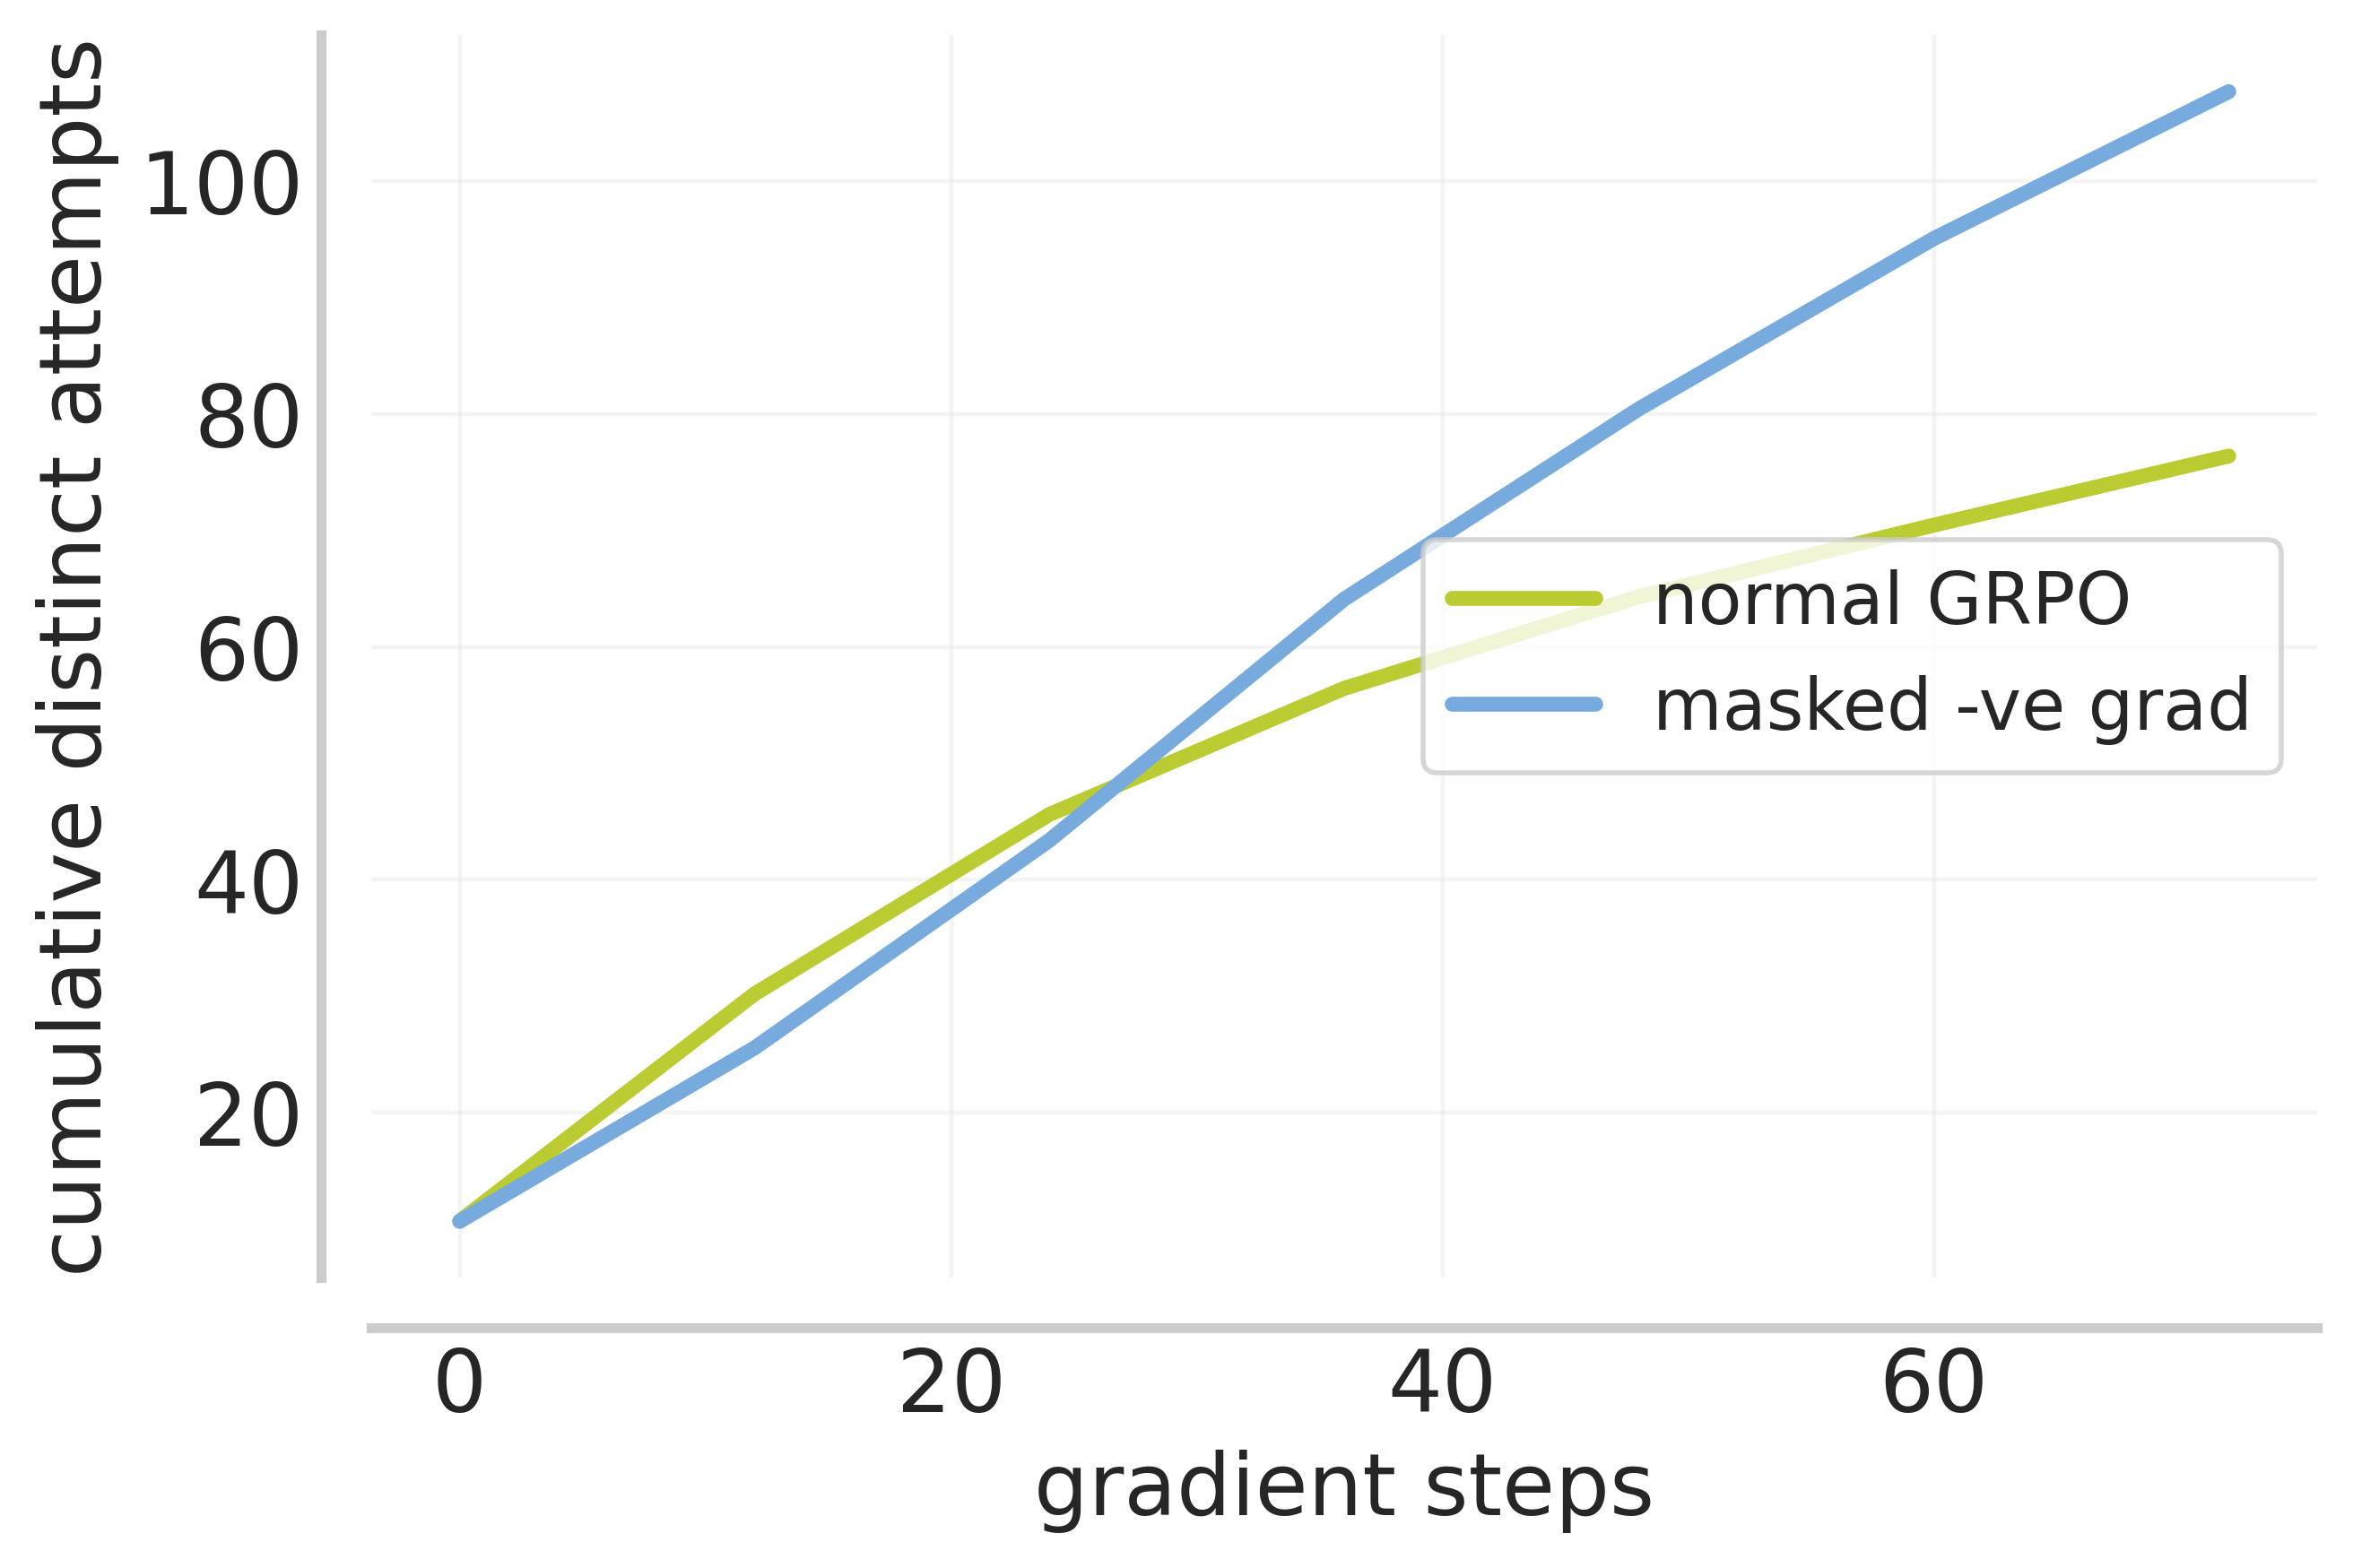

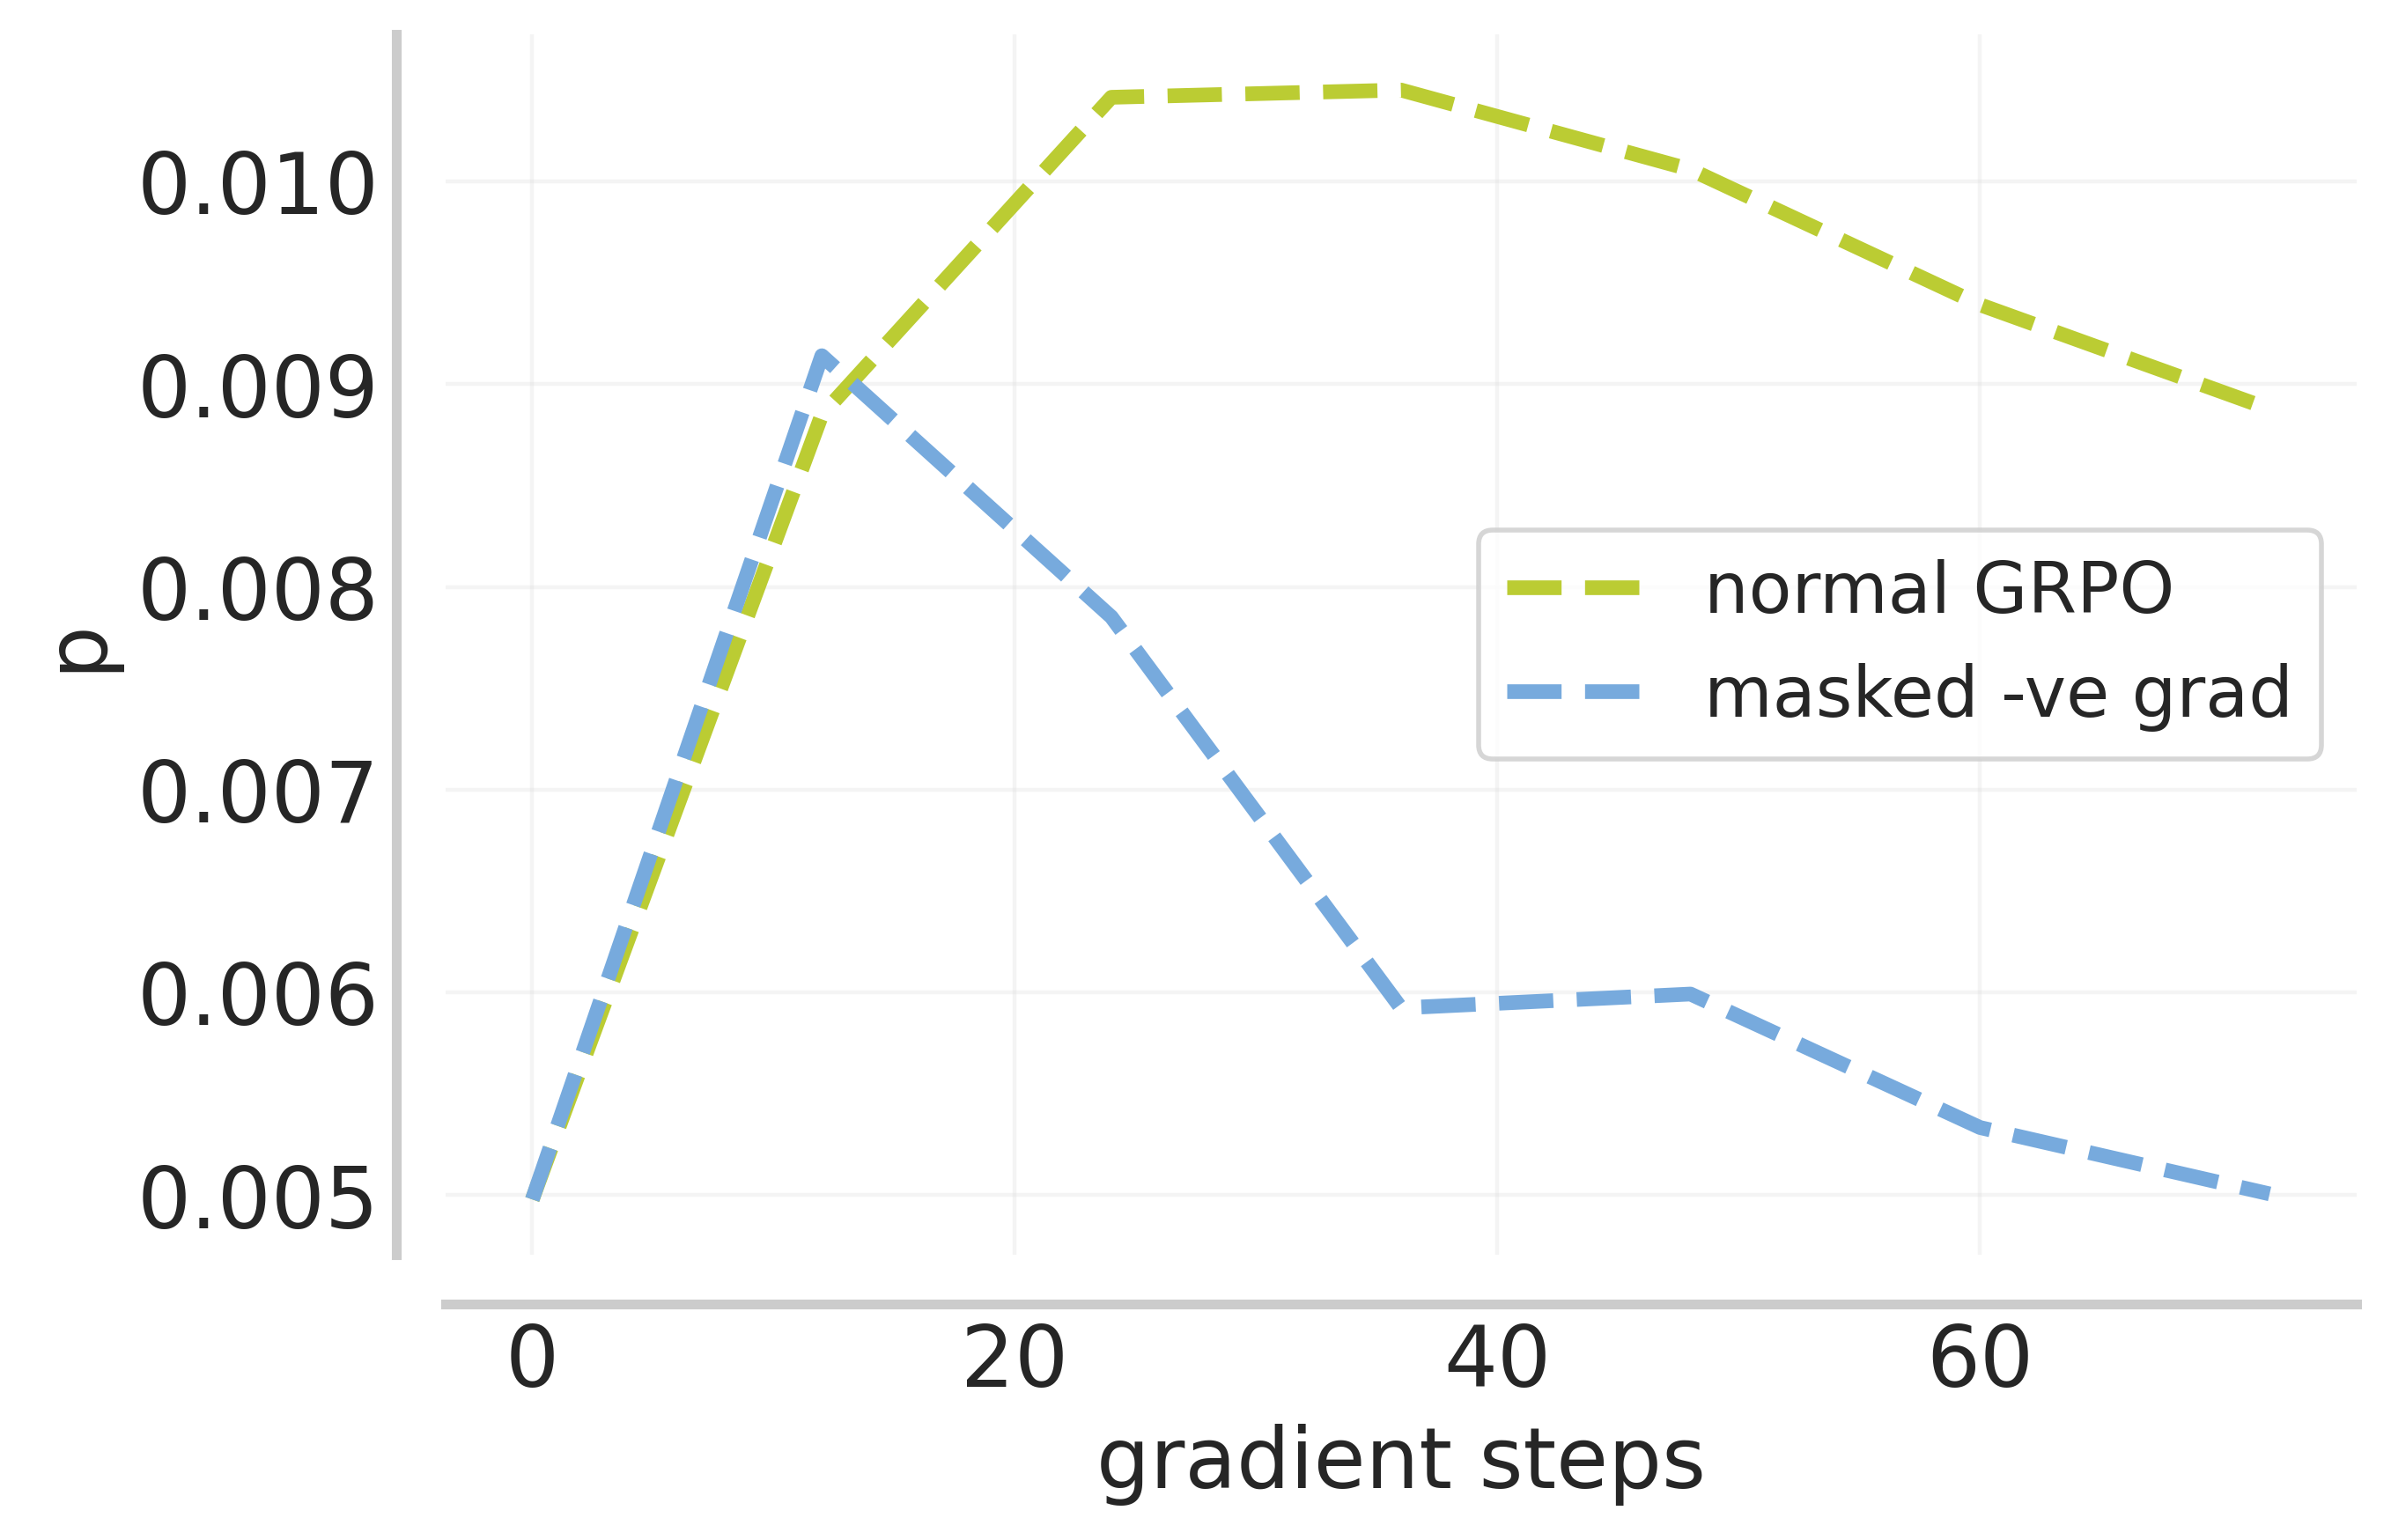

In [23]:
k_fig, k_ax = plt.subplots(figsize=(14 / 2, 4.5), dpi=400)
p_fig, p_ax = plt.subplots(figsize=(14 / 2, 4.5), dpi=400)


for folder in ['normal', 'positive']:
    k = []
    p = []
    problem_to_cum_attempts = defaultdict(set)
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        
        attempts = 0
        successes = 0
        total = 0
        for i in range(len(rollouts) // 8):
            if rollouts[i * 8]['ref_score'] != 5:
                continue

            for j in range(8):
                rollout = rollouts[i * 8 + j]

                for attempt in set(rollout['output'].split('\n\n')):
                    problem_to_cum_attempts[i].add('\n'.join(extract_equations(attempt)))

                successes += rollout['score']
                total += 1
            
            attempts += len(problem_to_cum_attempts[i])

        k.append(attempts / total)
        p.append(successes / attempts)

    if folder == 'normal':
        text = "normal GRPO"
    else:
        text = "masked -ve grad"

    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=k, ax=k_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', linestyle='-')
    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=p, ax=p_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}',  linestyle='--')


plt.rcParams["legend.loc"] = "center right"

plot_utils._annotate_and_decorate_axis(k_ax,
                                        xlabel='gradient steps',
                                        ylabel='cumulative distinct attempts',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

plot_utils._annotate_and_decorate_axis(p_ax,
                                        xlabel='gradient steps',
                                        ylabel='p',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)
plt.show()